##Classification of US quarters and Euro coins

testing our model trained on quarters dataset


In [ ]:
# load data from google drive
!unzip /content/drive/MyDrive/data_quarters.zip

Archive:  /content/drive/MyDrive/data_quarters.zip
   creating: images_sorted/
   creating: images_sorted/US.Quarter.2020.Vermont.Reverse/
   creating: images_sorted/US.Quarter.2021.Alabama.Reverse/
   creating: images_sorted/US.Quarter.2005.Oregon.Reverse/
   creating: images_sorted/US.Quarter.2010.Oregon.Reverse/
   creating: images_sorted/US.Quarter.Obverse/
   creating: images_sorted/US.Quarter.2001.New York.Reverse/
   creating: images_sorted/US.Quarter.2019.Northern Mariana Islands.Reverse/
   creating: images_sorted/US.Quarter.1999.Pennsylvania.Reverse/
   creating: images_sorted/US.Quarter.2018.Rhode Island.Reverse/
   creating: images_sorted/US.Quarter.2015.Louisiana.Reverse/
   creating: images_sorted/US.Quarter.2020.U.S. Virgin Islands.Reverse/
   creating: images_sorted/US.Quarter.2015.North Carolina.Reverse/
   creating: images_sorted/US.Quarter.2015.New York.Reverse/
   creating: images_sorted/US.Quarter.2018.Georgia.Reverse/
   creating: images_sorted/US.Quarter.2007.Uta

In [ ]:
# find empty directories and delete them

!find images_sorted -type d -empty -exec rmdir {} \;


find: ‘images_sorted/US.Quarter.2021.Alabama.Reverse’: No such file or directory
find: ‘images_sorted/US.Quarter.2009.US Virgin Islands.Reverse’: No such file or directory


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

import keras
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import matplotlib.pyplot as plt

from keras import backend as K




from keras.applications import resnet50


import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot



import time




In [ ]:
batch_size = 32
img_height = 256
img_width =  256

In [ ]:
# data generators

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2)

train_generator = datagen.flow_from_directory(
                    'images_sorted',
                    target_size=(img_height, img_width),
                    batch_size=batch_size,
                    shuffle=True,
                    seed=123,
                    subset='training')


valid_generator = datagen.flow_from_directory(
                    'images_sorted',
                    target_size=(img_height, img_width),
                    batch_size=batch_size,
                    shuffle=True,
                    seed=123,
                    subset='validation')
        





Found 1043 images belonging to 111 classes.
Found 187 images belonging to 111 classes.


In [ ]:
X_train=[]
y_train=[]

train_generator.reset()

for i in range(train_generator.__len__()):
   a,b=train_generator.next()
   X_train.extend(a)
   y_train.extend(b)


X_train=np.array(X_train)
y_train=np.array(y_train)

In [ ]:
X_valid=[]
y_valid=[]

valid_generator.reset()

for i in range(valid_generator.__len__()):
   a,b=valid_generator.next()
   X_valid.extend(a)
   y_valid.extend(b)


X_valid=np.array(X_valid)
y_valid=np.array(y_valid)


In [ ]:
n_classes=len(y_train[0])
n_classes

111

In [ ]:
y_train = np.array([y_train[i].tolist().index(1) for i in range(len(y_train))])
y_valid = np.array([y_valid[i].tolist().index(1) for i in range(len(y_valid))])

In [ ]:
# Data augmentation

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=180,
            zoom_range=0.5,
            height_shift_range=0.1,
            width_shift_range=0.1)

In [ ]:
def get_pairs(batch_size,test=False):

  if test:

    X = X_valid
    y = y_valid
    
  else:

    X = X_train
    y = y_train


   

  n, img_height,img_width, c = X_train.shape

  pairs=[np.zeros((batch_size, img_height, img_width,c)) for i in range(2)]
  targets=np.zeros((batch_size))

  targets[batch_size//2:] = 1




  for i in range(batch_size):

    
    idx1 = np.random.randint(0,n)

    pairs[0][i,:,:,:] = data_augmentation.flow(X[idx1:idx1+1])[0][0] # apply data augmentation


    idx2 = np.random.randint(0,n)

    # first half of the set: images are from different classes
    if i < batch_size//2 :
      
      
      while y[idx1] == y[idx2]:  # if from same class

        idx2 = np.random.randint(0,n)  #try another random index
    
    # second half of the set: images are from the same class

    # this part was rewritten to optimize generation from large datasets

    if i >= batch_size//2 :
      
      
      y0 = y[idx1]

      # generate an array of indices of the elements from the same class as element idx1
      indices = [i for i, y in enumerate(y_train) if y == y0]
      
      # and get a random element from this array
      idx2 = indices[ np.random.randint(0,len(indices))]

     

    pairs[1][i,:,:,:] = data_augmentation.flow(X[idx2:idx2+1])[0][0]  # apply data augmentation



  return pairs, targets

In [ ]:
def pairs_generator(batch_size, test = False):
    while True:
        pairs, targets = get_pairs(batch_size,test = test)
        yield (pairs, targets)

In [ ]:
# load previously trained model

import_path_keras='/content/drive/MyDrive/models/siamese_quarters/1608316269.h5'

model = tf.keras.models.load_model(import_path_keras)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2048)         23587712    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2048)         0           sequential_1[0][0]         

In [ ]:
def one_shot_task(X_valid1,X_train,y_train):

  pairs=[np.zeros((n_classes, img_height, img_width,3)) for i in range(2)]

  n_samples = len(y_train)

  for i in range(n_classes):

     pairs[0][i,:,:,:] = X_valid1





  for i in range(n_classes):

   
     # this part was rewritten to optimize speed:


     # generate an array of indices of the elements from the same class as element idx1
     indices = [j for j, y in enumerate(y_train) if y == i]
      
     # and get a random element from this array
     idx2 = indices[ np.random.randint(0,len(indices))]

     pairs[1][i,:,:,:] = X_train[idx2]

  return pairs

In [ ]:
def test_accuracy(X_valid,y_valid,X_train,y_train):

  n_correct = 0
  n_all = len(X_valid)

  for i in range(n_all):

    pred = np.argmax( model.predict(one_shot_task(X_valid[i],X_train,y_train)) )

    if y_valid[i] == pred:

      n_correct+=1

      if i!=0 and i%10 == 0: print('step:', i, 'accuracy:', 100 * n_correct/(i+1))

  accuracy = 100.0 * n_correct / n_all
  print('step:', n_all, 'accuracy:',  accuracy)


  return accuracy



True label: US.Quarter.Obverse
Predicted label: US.Quarter.Obverse


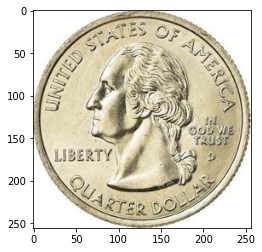

In [ ]:
# get random image from validation dataset

i1=np.random.randint(0,len(X_valid))

X_valid1=X_valid[i1]
y_valid1=y_valid[i1]


# show image

plt.imshow(X_valid1)


# true label:

dict1 = valid_generator.class_indices
inv_dict1 = {v: k for k, v in dict1.items()}

true_label = inv_dict1[y_valid1]


# predicted label

y_pred = np.argmax( model.predict(one_shot_task(X_valid1,X_train,y_train)) )

dict2 = train_generator.class_indices
inv_dict2 = {v: k for k, v in dict2.items()}

pred_label = inv_dict2[y_pred]




print("True label:", true_label)
print("Predicted label:", pred_label)

In [ ]:
# test images downloaded from the internet


In [ ]:
# load data from google drive
!unzip /content/drive/MyDrive/quarters_test.zip

Archive:  /content/drive/MyDrive/quarters_test.zip
   creating: quarters_test/
  inflating: quarters_test/daadc366-9612-433b-974c-59a702c5606f.jpeg  
  inflating: quarters_test/cb60a6513c17e02e8e71139e55d2253e.jpg  
  inflating: quarters_test/istockphoto-517076027-612x612.jpg  
  inflating: quarters_test/maxresdefault.jpg  
  inflating: quarters_test/us-quarter-dollar-coin-isolated-dark-background-closeup-us-quarter-dollar-coin-dark-background-105165700.jpg  
  inflating: quarters_test/gettyimages-95380118-612x612.jpg  
  inflating: quarters_test/1999-United-States-Of-America-Quarter-Dollar-Letter.jpg  


In [ ]:
datagen_test= tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            )



test_generator = datagen_test.flow_from_directory(
                    'quarters_test',
                    target_size=(img_height, img_width),
                    batch_size=batch_size,
                    shuffle=False,
                    seed=123)


Found 7 images belonging to 2 classes.


In [ ]:
X_test=[]
y_test=[]

test_generator.reset()

for i in range(test_generator.__len__()):
   a,b=test_generator.next()
   X_test.extend(a)
   y_test.extend(b)


X_test=np.array(X_test)
y_test=np.array(y_test)

In [ ]:
y_test = np.array([y_test[i].tolist().index(1) for i in range(len(y_test))])


True label: unknown
Predicted label: US.Quarter.2006.North Dakota.Reverse


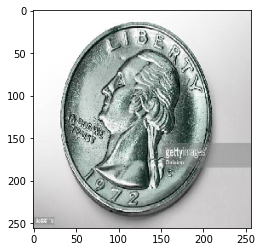

In [ ]:
# get random image from test dataset

i1=np.random.randint(0,len(X_test))

X_test1=X_test[i1]
y_test1=y_test[i1]


# show image

plt.imshow(X_test1)


# true label:

dict1 = test_generator.class_indices
inv_dict1 = {v: k for k, v in dict1.items()}

true_label = inv_dict1[y_test1]


# predicted label

y_pred = np.argmax( model.predict(one_shot_task(X_test1,X_train,y_train)) )

dict2 = train_generator.class_indices
inv_dict2 = {v: k for k, v in dict2.items()}

pred_label = inv_dict2[y_pred]




print("True label:", true_label)
print("Predicted label:", pred_label)